In [1]:
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report,recall_score, precision_score, f1_score
import seaborn as sns
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 1. Data Preprocessing

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])


# 2. Load CIFAR10

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = torch.utils.data.random_split(trainset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {len(testset)}")


100%|██████████| 170M/170M [01:23<00:00, 2.04MB/s]


Train size: 40000, Val size: 10000, Test size: 10000


# 3. Load ResNet-18

In [5]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 10)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 214MB/s]


# 4. Train Model

In [ ]:
epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"\nStarting training for {epochs} epochs...")
start_time = time.time()

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss, running_corrects = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects.double() / len(train_subset)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    # Validation phase
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / len(val_loader)
    val_acc = val_running_corrects.double() / len(val_subset)
    val_losses.append(val_loss)
    val_accs.append(val_acc.item())

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


Starting training for 10 epochs...
Epoch [1/10] Train Loss: 1.7085, Train Acc: 0.3906 | Val Loss: 1.3038, Val Acc: 0.5377
Epoch [2/10] Train Loss: 1.2414, Train Acc: 0.5625 | Val Loss: 1.1125, Val Acc: 0.6071
Epoch [3/10] Train Loss: 1.0853, Train Acc: 0.6249 | Val Loss: 1.0125, Val Acc: 0.6457
Epoch [4/10] Train Loss: 1.0030, Train Acc: 0.6512 | Val Loss: 0.9409, Val Acc: 0.6721
Epoch [5/10] Train Loss: 0.9375, Train Acc: 0.6757 | Val Loss: 0.9120, Val Acc: 0.6845
Epoch [6/10] Train Loss: 0.8832, Train Acc: 0.6936 | Val Loss: 0.8594, Val Acc: 0.7009
Epoch [7/10] Train Loss: 0.8500, Train Acc: 0.7053 | Val Loss: 0.8342, Val Acc: 0.7153
Epoch [8/10] Train Loss: 0.8174, Train Acc: 0.7171 | Val Loss: 0.8111, Val Acc: 0.7223
Epoch [9/10] Train Loss: 0.7890, Train Acc: 0.7275 | Val Loss: 0.7947, Val Acc: 0.7221
Epoch [10/10] Train Loss: 0.7687, Train Acc: 0.7332 | Val Loss: 0.7834, Val Acc: 0.7310

Training completed in 445.14 seconds (7.42 minutes)


In [ ]:
epoch_hist = pd.DataFrame({
    "Epoch": range(1, epochs+1),
    "Train Loss": train_losses,
    "Train Acc": train_accs,
    "Val Loss": val_losses,
    "Val Acc": val_accs
})

# 5. Save Model

In [6]:
from google.colab import drive
drive.mount('/content/drive')

output_dir = "/content/drive/My Drive/Colab Notebooks/CIFAR10_ResNet18_Training"
os.makedirs(output_dir, exist_ok=True)
path_model = os.path.join(output_dir, "resnet18_cifar10_trained1.pth")
path_epoch_hist = os.path.join(output_dir, "epoch_hist1.csv")

Mounted at /content/drive


In [ ]:
# Save model and history
torch.save(model.state_dict(), path_model)
epoch_hist.to_csv(path_epoch_hist, index=False)
print(f"\nModel saved to: {path_model}")
print(f"Epoch history saved to: {path_epoch_hist}")


Model saved to: ./resnet18_cifar10_trained1.pth
Epoch history saved to: ./epoch_hist1.csv


# 6. Load Model (for later use)


In [7]:
model.load_state_dict(torch.load(path_model))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 7. Test Model

In [8]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
print("\nEvaluating on test set...")
correct, total = 0, 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

report_dict = classification_report(all_labels, all_preds, target_names=classes, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
F1_Score = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

print(f"Test F1 Score (macro avg): {F1_Score}")
print(f"Test Precision (macro avg): {precision}")
print(f"Test Recall (macro avg): {recall}")


Evaluating on test set...
Test Accuracy: 0.7744 (77.44%)
Test F1 Score (macro avg): 0.7716996938049476
Test Precision (macro avg): 0.7732252835149522
Test Recall (macro avg): 0.7744000000000001


# 8. Predict on One Image


In [11]:
sample_img, sample_label = testset[0]
sample_img_batch = sample_img.unsqueeze(0).to(device)

start_infer = time.time()
output = model(sample_img_batch)
infer_time = time.time() - start_infer
_, pred = torch.max(output, 1)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

print(f"\nSingle Image Prediction:")
print(f"Predicted label: {pred.item()} ({classes[pred.item()]})")
print(f"True label: {sample_label} ({classes[sample_label]})")
print(f"Inference time: {infer_time*1000:.2f} ms")


Single Image Prediction:
Predicted label: 3 (cat)
True label: 3 (cat)
Inference time: 8.75 ms


# 9. Output Plots


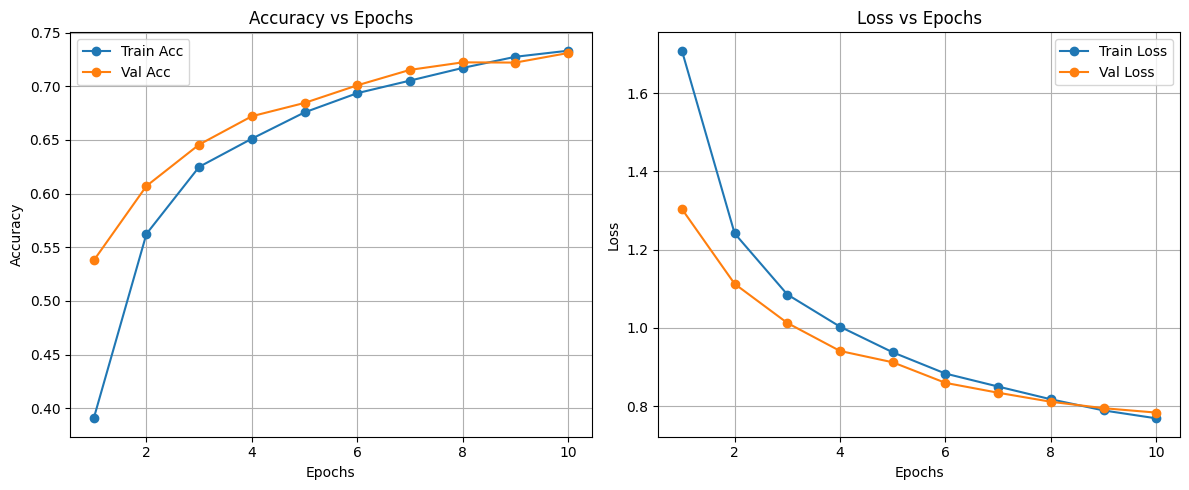

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accs, label="Train Acc", marker='o')
plt.plot(range(1, epochs+1), val_accs, label="Val Acc", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, epochs+1), val_losses, label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# 10. Summary Statistics


In [17]:
summary_file = os.path.join(output_dir, "summary_metrics.csv")
model_size = os.path.getsize(path_model) / 1e6

if os.path.exists(summary_file):
    # Load the saved summary if it already exists
    summary_df = pd.read_csv(summary_file)
    print("\n" + "="*70)
    print("Loaded Summary")
    print("="*70)
    print(f"\033[1m{summary_df.T}")
else:
    # Only run this block after training is complete
    summary_df = pd.DataFrame([{
      "Model": "ResNet-18",
      "Dataset": "CIFAR-10",
      "Test Accuracy": test_acc,
      "Traing Accuracy": pd.read_csv(os.path.join(path_epoch_hist))["Train Acc"].iloc[-1],
      "Validation Accuracy": pd.read_csv(os.path.join(path_epoch_hist))["Val Acc"].iloc[-1],
      "Training Loss": pd.read_csv(os.path.join(path_epoch_hist))["Train Loss"].iloc[-1],
      "Precision": precision,
      "F1-Score": F1_Score,
      "Recall": recall,
      "Inference Time (ms)": infer_time * 1000,
      "Model Size (MB)": model_size,
      "Training Time (s)": training_time
    }])

    summary_df.to_csv(summary_file, index=False)
    print("\n" + "="*70)
    print("Saved Summary")
    print("="*70)
    print(f"\033[1m{summary_df.T}")


Saved Summary
                             0
Model                ResNet-18
Dataset               CIFAR-10
Test Accuracy           0.7744
Traing Accuracy        0.73315
Validation Accuracy      0.731
Training Loss         0.768736
Precision             0.773225
F1-Score                0.7717
Recall                  0.7744
Inference Time (ms)   8.749008
Model Size (MB)      44.808203
Training Time (s)       445.14


# 11. Confusion Matrix



GENERATING CONFUSION MATRIX


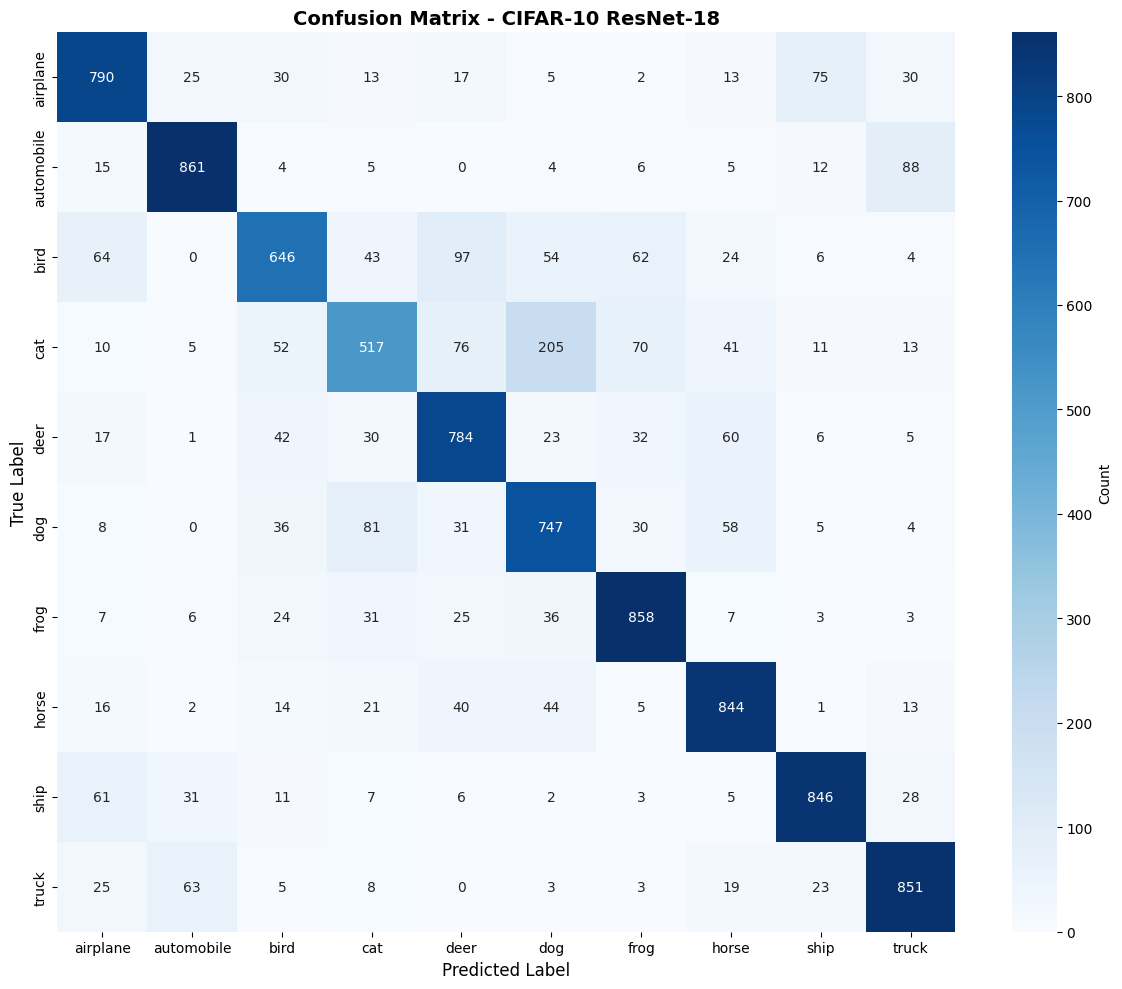

✓ Confusion matrix saved as 'confusion_matrix.png'


In [ ]:
print("\n" + "="*70)
print("GENERATING CONFUSION MATRIX")
print("="*70)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - CIFAR-10 ResNet-18', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'confusion_matrix.png'")

# 12. Classification Report


In [ ]:
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)

report_dict = classification_report(all_labels, all_preds, target_names=classes, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Save classification report to a CSV file
report_csv_path = './classification_report.csv'
report_df.to_csv(report_csv_path, index=True)
print(f"\n✓ Classification report saved as '{report_csv_path}'")


# Per-class accuracy
class_correct = [0] * 10
class_total = [0] * 10
for i in range(len(all_labels)):
    label = all_labels[i]
    class_correct[label] += (all_preds[i] == label)
    class_total[label] += 1

print("\n" + "="*70)
print("PER-CLASS ACCURACY AND TRUE POSITIVES")
print("="*70)
for i in range(10):
    acc = 100 * class_correct[i] / class_total[i]
    true_positives = cm[i, i]
    print(f'{classes[i]:12s}: {acc:6.2f}% ({class_correct[i]:4d}/{class_total[i]:4d}) | True Positives: {true_positives}')

print("\n" + "="*70)
print("CLASSIFICATION REPORT DATAFRAME")
print("="*70)
display(report_df)


CLASSIFICATION REPORT

✓ Classification report saved as './classification_report.csv'

PER-CLASS ACCURACY AND TRUE POSITIVES
airplane    :  79.00% ( 790/1000) | True Positives: 790
automobile  :  86.10% ( 861/1000) | True Positives: 861
bird        :  64.60% ( 646/1000) | True Positives: 646
cat         :  51.70% ( 517/1000) | True Positives: 517
deer        :  78.40% ( 784/1000) | True Positives: 784
dog         :  74.70% ( 747/1000) | True Positives: 747
frog        :  85.80% ( 858/1000) | True Positives: 858
horse       :  84.40% ( 844/1000) | True Positives: 844
ship        :  84.60% ( 846/1000) | True Positives: 846
truck       :  85.10% ( 851/1000) | True Positives: 851

CLASSIFICATION REPORT DATAFRAME


,precision,recall,f1-score,support
airplane,0.779862,0.7900,0.784898,1000.0000
automobile,0.866197,0.8610,0.863591,1000.0000
bird,0.747685,0.6460,0.693133,1000.0000
cat,0.683862,0.5170,0.588838,1000.0000
deer,0.728625,0.7840,0.755299,1000.0000
dog,0.665183,0.7470,0.703721,1000.0000
frog,0.801120,0.8580,0.828585,1000.0000
horse,0.784387,0.8440,0.813102,1000.0000
ship,0.856275,0.8460,0.851107,1000.0000
truck,0.819057,0.8510,0.834723,1000.0000


# 13. Visualize Sample Predictions



GENERATING SAMPLE PREDICTIONS


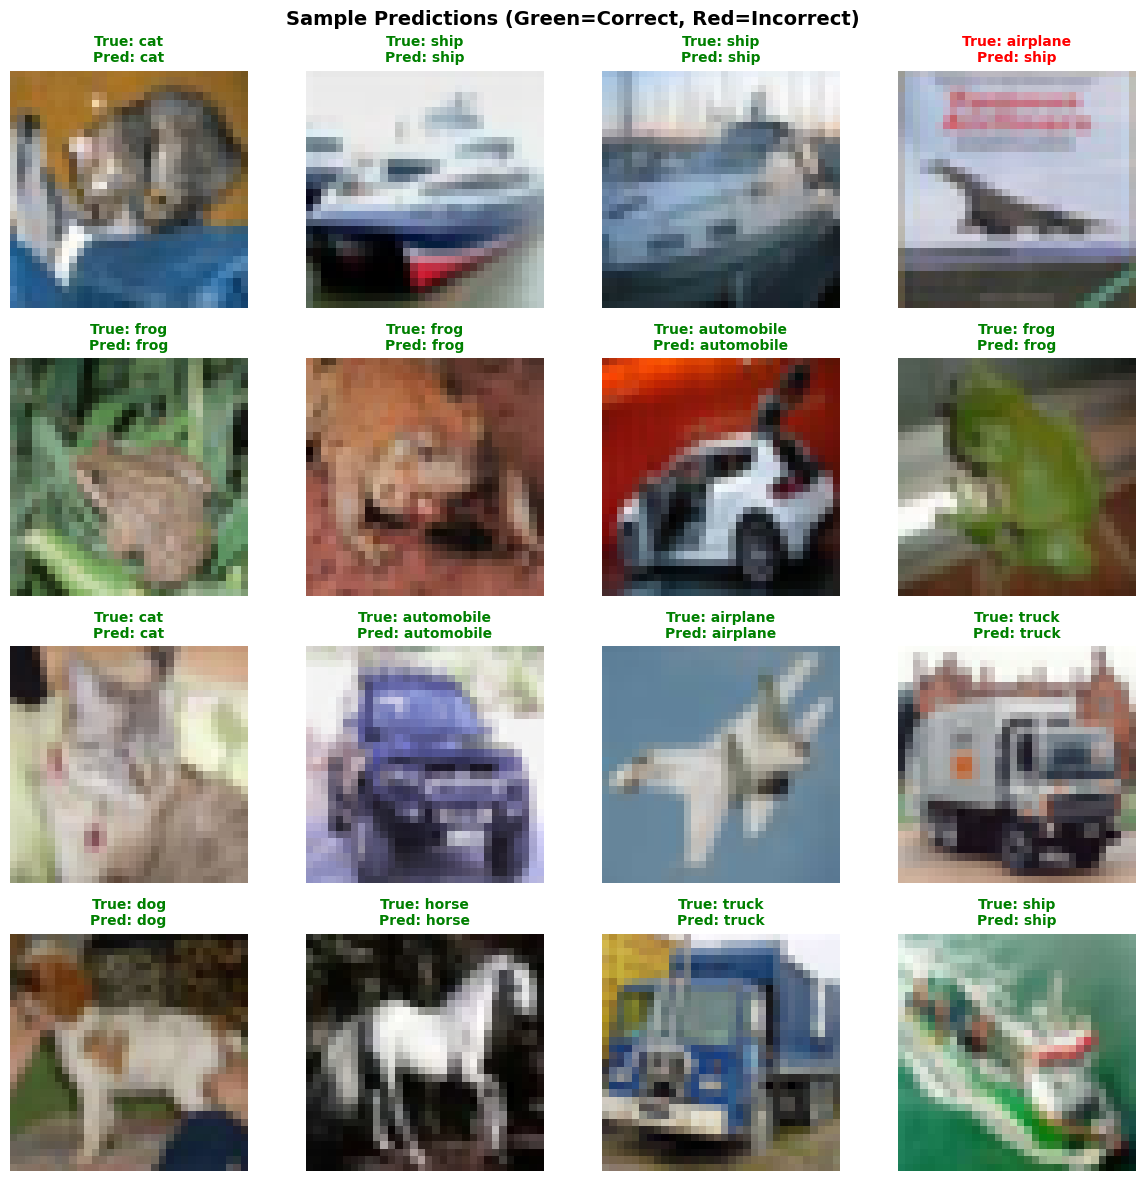

✓ Sample predictions saved as 'sample_predictions.png'


In [ ]:
print("\n" + "="*70)
print("GENERATING SAMPLE PREDICTIONS")
print("="*70)

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot first 16 images with predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        # Denormalize image for display
        img = images[idx].cpu()
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        img = img + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)

        ax.imshow(img.permute(1, 2, 0))

        true_label = classes[labels[idx].item()]
        pred_label = classes[predicted[idx].item()]
        color = 'green' if labels[idx] == predicted[idx] else 'red'

        ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                     color=color, fontsize=10, fontweight='bold')
        ax.axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Sample predictions saved as 'sample_predictions.png'")